# Notes
This is the notebook for training and running the Multi-Task model:
 - A single image is passed into the YOLOv8 backbone, resulting in a feature vector
 - This feature vector is then sent to a classification head which predicts good/bad, as well as logits for ALL unique metadata values present in the training set. That is, it predicts a single logit for each unique grit step and grind time value.
 - After argmax, predictions for the main label (good bad), the grit step, and the grind time are made and used to calculate a loss for each. Separate loss surfaces for good/bad, grit step, and grind time are made. The grit step and grind time surfaces are added (with significant scaled down amplitude) to the good/bad surface, and then gradient descent is performed.

I have all of the models get training data from a directory structure. This design decision was influenced by YOLO itself - before I used the classification variant I was labeling the training data in label studio and making bounding boxes, and I had to use this directory structure. It is now no critical to the design of the model, but it works well.

# Notes

## SET MODEL SETTINGS

In [1]:
# Set to either 'grind_trial' or 'polish_trial'
train_type = 'polish_trial'
# The trial number (1-5)
trial_num = 5

# Set the training data pickle file name string
data_batch_file_str = f'train_batch_{train_type}_df.pkl'

# Set the custom identifier for the output model metrics files
# Choose a unique one.
variant_name = f'{trial_num}{train_type}'

# Sometimes it's useful to run this notebook without training
start_training = True

# Batch size and number of workers:
batch_size = 16
num_workers = 4
# Jitter params
jitter_params = dict(brightness=0.1, contrast=0.1, saturation=0, hue=0)

## Obtain Project Directory

In [2]:
from pathlib import Path
notebook_dir = Path.cwd()
parent_dir = notebook_dir.parent.parent
print(parent_dir)

c:\Users\jackson129\OneDrive - LLNL\APEX_Cornell_Analysis


## * Important! * - Check Model Seed

In [3]:
# Print Model Seed. It should match what is in seed_main.
# If it does not, restart this notebook to refresh __pycache__
from seed import SEED
print(SEED)

2003


## Load in the Training Data from the Analysis Notebook

In [4]:
import pickle

with open(parent_dir / 'orchestrator' / data_batch_file_str, 'rb') as f:
    df = pickle.load(f)

display(df)

,image_id,label,grit_time,grit_step,image
0,420,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
9,421,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
18,422,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
27,423,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
36,424,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
...,...,...,...,...,...
152,772,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
161,773,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
170,774,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
179,775,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...


## Create the Directory Structure, Text Files (for bounding boxes), and All Other Files Needed For YOLO

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
from seed import SEED
import numpy as np
import torch
import random

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(SEED)

# Assume df exists with columns: ['image_id', 'grind_time', 'grit', 'image', 'label']

# Split into train/val
train_df, val_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=SEED
)

# Define folders
base = 'dataset'  # Or your dataset root path

# Remove the dataset folder if it exists
if os.path.exists(base):
    shutil.rmtree(base)

# Recreate the base dataset folder
os.makedirs(base, exist_ok=True)

def save_subset_cls(df, subset):
    for _, row in df.iterrows():
        img_id = row['image_id']
        image  = row['image']
        cls    = row['label']

        # Create class subfolder
        class_folder = os.path.join(base, subset, str(cls))
        os.makedirs(class_folder, exist_ok=True)

        # Save image
        img_path = os.path.join(class_folder, f"{img_id}.jpg")
        image.save(img_path, format='JPEG', quality=95)

# Save images in the new structure
save_subset_cls(train_df, 'train')
save_subset_cls(val_df, 'val')

# Save train and val metadata
train_metadata = train_df[['image_id', 'grit_time', 'grit_step', 'label']].copy()
train_metadata.to_csv(os.path.join(base, 'train_metadata.csv'), index=False)

val_metadata = val_df[['image_id', 'grit_time', 'grit_step', 'label']].copy()
val_metadata.to_csv(os.path.join(base, 'val_metadata.csv'), index=False)

# Optionally, save metadata if you still need it for analysis
md = df[['image_id','grit_time','grit_step','label']].copy()
md.to_csv(os.path.join(base, 'metadata.csv'), index=False)


# Automatically discover unique categories for grit_step and grit_time
grit_steps = sorted(train_metadata['grit_step'].unique())
grit_times = sorted(train_metadata['grit_time'].unique())
NUM_GRIT_STEPS = len(grit_steps)
NUM_GRIT_TIMES = len(grit_times)
print('grit', NUM_GRIT_STEPS)
print(NUM_GRIT_TIMES)

# Build mappings: category value <-> index
grit_step2idx = {g: i for i, g in enumerate(grit_steps)}
idx2grit_step = {i: g for g, i in grit_step2idx.items()}

grit_time2idx = {g: i for i, g in enumerate(grit_times)}
idx2grit_time = {i: g for g, i in grit_time2idx.items()}

# For reference, print discovered categories
print("Discovered grit_step categories:", grit_steps)
print("Discovered grit_time categories:", grit_times)
print("grit_step2idx mapping:", grit_step2idx)
print("grit_time2idx mapping:", grit_time2idx)


# Check for overlap in image_id
overlap = set(train_df['image_id']) & set(val_df['image_id'])
if overlap:
    print(f"Data leakage detected! Overlapping image_ids: {overlap}")
else:
    print("No data leakage detected at the image_id level.")

2003
grit 3
7
Discovered grit_step categories: [np.float64(0.08), np.float64(0.3), np.float64(1.0)]
Discovered grit_time categories: [np.int64(60), np.int64(120), np.int64(180), np.int64(300), np.int64(360), np.int64(900), np.int64(3600)]
grit_step2idx mapping: {np.float64(0.08): 0, np.float64(0.3): 1, np.float64(1.0): 2}
grit_time2idx mapping: {np.int64(60): 0, np.int64(120): 1, np.int64(180): 2, np.int64(300): 3, np.int64(360): 4, np.int64(900): 5, np.int64(3600): 6}
No data leakage detected at the image_id level.


Train samples: 528
  Val samples: 57
Sample shapes:
  image: torch.Size([3, 640, 640])
  class_label: 0
  grit_step_idx: 2
  grit_time_idx: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.443468..0.9925628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.483892..0.8106553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4030442..1.3765898].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2211366..1.3765898].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5041041..1.3765898].


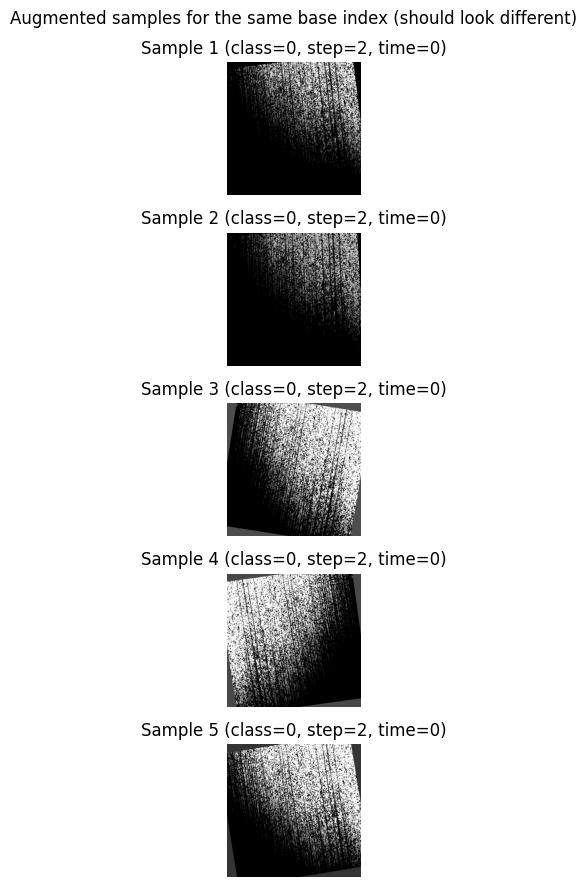

In [6]:
import torch
from torch.utils.data import DataLoader
from dataset import GrindingDataset, SingleImageTransform

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)

# Define transforms
train_transform = SingleImageTransform(
    image_size=(640, 640),
    train=True,
    flip_prob=0.5,
    rotation_degrees=10,
    jitter_params=jitter_params
)

val_transform = SingleImageTransform(
    image_size=(640, 640),
    train=False
)

# Build datasets
train_ds = GrindingDataset(
    images_dir="dataset/train",
    metadata_csv="dataset/train_metadata.csv",
    grit_step2idx=grit_step2idx,
    grit_time2idx=grit_time2idx,
    filename_col="image_id",
    transform=train_transform,
    aug_factor=4,
)

val_ds = GrindingDataset(
    images_dir="dataset/val",
    metadata_csv="dataset/val_metadata.csv",
    grit_step2idx=grit_step2idx,
    grit_time2idx=grit_time2idx,
    filename_col="image_id",
    transform=val_transform
)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train samples: {len(train_ds)}")
print(f"  Val samples: {len(val_ds)}")

# Inspect a sample
img, (class_label, grit_step_idx, grit_time_idx) = train_ds[0]
print("Sample shapes:")
print("  image:", img.size())
print("  class_label:", class_label)
print("  grit_step_idx:", grit_step_idx)
print("  grit_time_idx:", grit_time_idx)

# Visualization (no meta)
import matplotlib.pyplot as plt

base_idx = 0
n_samples = 5

fig, axes = plt.subplots(n_samples, 1, figsize=(4, 9))
fig.suptitle("Augmented samples for the same base index (should look different)")

for i in range(n_samples):
    idx = base_idx + i * len(train_ds.df)
    img, (class_label, grit_step_idx, grit_time_idx) = train_ds[idx]
    img_np = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img_np)
    axes[i].set_title(f"Sample {i+1} (class={class_label}, step={grit_step_idx}, time={grit_time_idx})")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time
from model import*

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Device selection ---
def get_default_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_default_device()
print(f"Using device: {device}")

learn_rate = 0.0001



# --- Model instantiation ---
model = GrindingYOLOMultiHeadClassifier(
    yolo_weights='yolov8n-cls.pt',
    num_main_classes=2,
    num_grit_steps=NUM_GRIT_STEPS,
    num_grit_times=NUM_GRIT_TIMES
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-2)
criterion_main = nn.CrossEntropyLoss()
criterion_step = nn.CrossEntropyLoss()
criterion_time = nn.CrossEntropyLoss()

num_epochs = 100

# --- Metric storage ---
all_epoch_metrics = []

num_train_batches = len(train_loader)
num_val_batches = len(val_loader)

steps_per_epoch = num_train_batches
total_steps = num_epochs * steps_per_epoch

"""
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learn_rate,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.05,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)
"""

main_weight = 1.0
aux_init_weight = 0.3
aux_final_weight = 0.1

def get_aux_weight(epoch, num_epochs, init_weight, final_weight):
    return init_weight + (final_weight - init_weight) * (epoch / num_epochs)

training_start_time = time.time()

if start_training:
    print(f'Training Started with learning rate {learn_rate}...')
    for epoch in range(1, num_epochs + 1):
        print('Epoch: ' + str(epoch) + '/' + str(num_epochs))
        aux_weight = get_aux_weight(epoch-1, num_epochs-1, aux_init_weight, aux_final_weight)
        print(f"  [INFO] Aux loss weight for this epoch: {aux_weight:.4f}")

        # ——— train ———
        model.train()
        running_loss = 0
        correct_main = correct_step = correct_time = 0
        total = 0

        with tqdm(train_loader, desc=f"Training  ", total=num_train_batches, colour='magenta') as pbar:
            for imgs, targets in train_loader:
                imgs = imgs.to(device)
                class_labels, grit_step_idx, grit_time_idx = [t.to(device) for t in targets]

                optimizer.zero_grad()
                class_logits, grit_step_logits, grit_time_logits = model(imgs)
                loss_main = criterion_main(class_logits, class_labels)
                loss_step = criterion_step(grit_step_logits, grit_step_idx)
                loss_time = criterion_time(grit_time_logits, grit_time_idx)
                loss = (main_weight * loss_main +
                        aux_weight * loss_step +
                        aux_weight * 0.1 * loss_time)
                loss.backward()
                optimizer.step()
                #scheduler.step()

                running_loss += loss.item() * class_labels.size(0)
                preds_main = class_logits.argmax(dim=1)
                preds_step = grit_step_logits.argmax(dim=1)
                preds_time = grit_time_logits.argmax(dim=1)
                correct_main += (preds_main == class_labels).sum().item()
                correct_step += (preds_step == grit_step_idx).sum().item()
                correct_time += (preds_time == grit_time_idx).sum().item()
                total += class_labels.size(0)

                pbar.set_postfix({
                    'Loss': running_loss / (total or 1),
                    'Main Acc': correct_main / (total or 1),
                    'Step Acc': correct_step / (total or 1),
                    'Time Acc': correct_time / (total or 1)
                })
                pbar.update(1)

        train_loss = running_loss / total
        train_main_acc = correct_main / total
        train_step_acc = correct_step / total
        train_time_acc = correct_time / total

        # ——— validate ———
        model.eval()
        val_running_loss = 0
        val_correct_main = val_correct_step = val_correct_time = 0
        val_total = 0
        all_val_preds_main = []
        all_val_labels_main = []
        all_val_probs_main = []
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Validation", total=num_val_batches, colour='green') as vbar:
                for imgs, targets in val_loader:
                    imgs = imgs.to(device)
                    class_labels, grit_step_idx, grit_time_idx = [t.to(device) for t in targets]
                    class_logits, grit_step_logits, grit_time_logits = model(imgs)
                    loss_main = criterion_main(class_logits, class_labels)
                    loss_step = criterion_step(grit_step_logits, grit_step_idx)
                    loss_time = criterion_time(grit_time_logits, grit_time_idx)
                    loss = (main_weight * loss_main +
                            aux_weight * loss_step +
                            aux_weight * 0.1 * loss_time)
                    preds_main = class_logits.argmax(dim=1)
                    preds_step = grit_step_logits.argmax(dim=1)
                    preds_time = grit_time_logits.argmax(dim=1)
                    val_running_loss += loss.item() * class_labels.size(0)
                    val_correct_main += (preds_main == class_labels).sum().item()
                    val_correct_step += (preds_step == grit_step_idx).sum().item()
                    val_correct_time += (preds_time == grit_time_idx).sum().item()
                    val_total += class_labels.size(0)
                    all_val_preds_main.extend(preds_main.cpu().numpy())
                    all_val_labels_main.extend(class_labels.cpu().numpy())

                    # --- prediction probabilities for main class (assumes binary classification) ---
                    if class_logits.shape[1] == 2:
                        probs = torch.softmax(class_logits, dim=1)[:, 1]  # Probability of class 1
                    else:
                        # If single output (logit), use sigmoid
                        probs = torch.sigmoid(class_logits).squeeze()
                    all_val_probs_main.extend(probs.detach().cpu().numpy())

                    vbar.set_postfix({
                        'Val Loss': val_running_loss / (val_total or 1),
                        'Main Acc': val_correct_main / (val_total or 1),
                        'Step Acc': val_correct_step / (val_total or 1),
                        'Time Acc': val_correct_time / (val_total or 1)
                    })
                    vbar.update(1)

        val_loss = val_running_loss / val_total
        val_main_acc = val_correct_main / val_total
        val_step_acc = val_correct_step / val_total
        val_time_acc = val_correct_time / val_total

        # --- Calculate and store extra metrics for main class ---
        precision = precision_score(all_val_labels_main, all_val_preds_main, zero_division=0)
        recall = recall_score(all_val_labels_main, all_val_preds_main, zero_division=0)
        f1 = f1_score(all_val_labels_main, all_val_preds_main, zero_division=0)
        try:
            roc_auc = roc_auc_score(all_val_labels_main, all_val_probs_main)
        except ValueError:
            roc_auc = 0.0

        print(f"Epoch {epoch}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, ROC AUC={roc_auc:.3f}")

        elapsed_time = time.time() - training_start_time

        # --- Store all metrics for this epoch ---
        all_epoch_metrics.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_main_acc": train_main_acc,
            "val_main_acc": val_main_acc,
            "train_step_acc": train_step_acc,
            "val_step_acc": val_step_acc,
            "train_time_acc": train_time_acc,
            "val_time_acc": val_time_acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "val_probs_main": all_val_probs_main,
            "val_true_labels": all_val_labels_main,
            "val_pred_labels": all_val_preds_main,
            "val_probs": all_val_probs_main,
            "time": elapsed_time,
        })

    # --- Save all epoch metrics to pickle ---
    with open(f"runs/run{variant_name}.pkl", "wb") as f:
        pickle.dump(all_epoch_metrics, f)
    print(f"Saved all epoch metrics to out{variant_name}.pkl")

    torch.save(model.state_dict(), f'saved_models/model_{variant_name}.pth')

Using device: cuda
2
3
7
Setup: Will run dynamic‐forward on modules [0:8]  Setup(Detect is at 9)
TASK 256
TASK 256
Training Started with learning rate 0.0001...
Epoch: 1/100
  [INFO] Aux loss weight for this epoch: 0.3000


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.95, Main Acc=0.702, Step Acc=0.544, Time Acc=0.0351] 


Epoch 1: Precision=0.684, Recall=0.542, F1=0.605, ROC AUC=0.846
Epoch: 2/100
  [INFO] Aux loss weight for this epoch: 0.2980


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.849, Main Acc=0.737, Step Acc=0.544, Time Acc=0.263]


Epoch 2: Precision=0.680, Recall=0.708, F1=0.694, ROC AUC=0.859
Epoch: 3/100
  [INFO] Aux loss weight for this epoch: 0.2960


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.781, Main Acc=0.772, Step Acc=0.544, Time Acc=0.368]


Epoch 3: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.862
Epoch: 4/100
  [INFO] Aux loss weight for this epoch: 0.2939


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.728, Main Acc=0.772, Step Acc=0.614, Time Acc=0.386]


Epoch 4: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.865
Epoch: 5/100
  [INFO] Aux loss weight for this epoch: 0.2919


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.687, Main Acc=0.772, Step Acc=0.632, Time Acc=0.386]


Epoch 5: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.874
Epoch: 6/100
  [INFO] Aux loss weight for this epoch: 0.2899


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.655, Main Acc=0.772, Step Acc=0.632, Time Acc=0.386]


Epoch 6: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.885
Epoch: 7/100
  [INFO] Aux loss weight for this epoch: 0.2879


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.634, Main Acc=0.772, Step Acc=0.649, Time Acc=0.351]


Epoch 7: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.879
Epoch: 8/100
  [INFO] Aux loss weight for this epoch: 0.2859


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.62, Main Acc=0.772, Step Acc=0.667, Time Acc=0.351] 


Epoch 8: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.881
Epoch: 9/100
  [INFO] Aux loss weight for this epoch: 0.2838


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.602, Main Acc=0.772, Step Acc=0.667, Time Acc=0.333]


Epoch 9: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.888
Epoch: 10/100
  [INFO] Aux loss weight for this epoch: 0.2818


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.591, Main Acc=0.772, Step Acc=0.684, Time Acc=0.333]


Epoch 10: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.895
Epoch: 11/100
  [INFO] Aux loss weight for this epoch: 0.2798


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.581, Main Acc=0.772, Step Acc=0.719, Time Acc=0.316]


Epoch 11: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.894
Epoch: 12/100
  [INFO] Aux loss weight for this epoch: 0.2778


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.573, Main Acc=0.772, Step Acc=0.649, Time Acc=0.281]


Epoch 12: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.899
Epoch: 13/100
  [INFO] Aux loss weight for this epoch: 0.2758


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.56, Main Acc=0.772, Step Acc=0.719, Time Acc=0.316] 


Epoch 13: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.902
Epoch: 14/100
  [INFO] Aux loss weight for this epoch: 0.2737


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.559, Main Acc=0.772, Step Acc=0.772, Time Acc=0.281]


Epoch 14: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.903
Epoch: 15/100
  [INFO] Aux loss weight for this epoch: 0.2717


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.547, Main Acc=0.772, Step Acc=0.719, Time Acc=0.281]


Epoch 15: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.907
Epoch: 16/100
  [INFO] Aux loss weight for this epoch: 0.2697


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.535, Main Acc=0.772, Step Acc=0.719, Time Acc=0.228]


Epoch 16: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.907
Epoch: 17/100
  [INFO] Aux loss weight for this epoch: 0.2677


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.53, Main Acc=0.807, Step Acc=0.719, Time Acc=0.228] 


Epoch 17: Precision=0.697, Recall=0.958, F1=0.807, ROC AUC=0.912
Epoch: 18/100
  [INFO] Aux loss weight for this epoch: 0.2657


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.524, Main Acc=0.772, Step Acc=0.772, Time Acc=0.228]


Epoch 18: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.910
Epoch: 19/100
  [INFO] Aux loss weight for this epoch: 0.2636


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.516, Main Acc=0.772, Step Acc=0.772, Time Acc=0.228]


Epoch 19: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.909
Epoch: 20/100
  [INFO] Aux loss weight for this epoch: 0.2616


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.508, Main Acc=0.772, Step Acc=0.789, Time Acc=0.228]


Epoch 20: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.918
Epoch: 21/100
  [INFO] Aux loss weight for this epoch: 0.2596


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.512, Main Acc=0.825, Step Acc=0.807, Time Acc=0.228]


Epoch 21: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.913
Epoch: 22/100
  [INFO] Aux loss weight for this epoch: 0.2576


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.505, Main Acc=0.807, Step Acc=0.772, Time Acc=0.228]


Epoch 22: Precision=0.697, Recall=0.958, F1=0.807, ROC AUC=0.922
Epoch: 23/100
  [INFO] Aux loss weight for this epoch: 0.2556


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.496, Main Acc=0.772, Step Acc=0.789, Time Acc=0.228]


Epoch 23: Precision=0.677, Recall=0.875, F1=0.764, ROC AUC=0.923
Epoch: 24/100
  [INFO] Aux loss weight for this epoch: 0.2535


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.494, Main Acc=0.825, Step Acc=0.772, Time Acc=0.228]


Epoch 24: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.924
Epoch: 25/100
  [INFO] Aux loss weight for this epoch: 0.2515


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.492, Main Acc=0.825, Step Acc=0.807, Time Acc=0.228]


Epoch 25: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.929
Epoch: 26/100
  [INFO] Aux loss weight for this epoch: 0.2495


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.485, Main Acc=0.807, Step Acc=0.825, Time Acc=0.228]


Epoch 26: Precision=0.697, Recall=0.958, F1=0.807, ROC AUC=0.926
Epoch: 27/100
  [INFO] Aux loss weight for this epoch: 0.2475


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, Val Loss=0.477, Main Acc=0.825, Step Acc=0.825, Time Acc=0.228]


Epoch 27: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.931
Epoch: 28/100
  [INFO] Aux loss weight for this epoch: 0.2455


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.473, Main Acc=0.825, Step Acc=0.807, Time Acc=0.228]


Epoch 28: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.936
Epoch: 29/100
  [INFO] Aux loss weight for this epoch: 0.2434


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.472, Main Acc=0.842, Step Acc=0.789, Time Acc=0.246]


Epoch 29: Precision=0.727, Recall=1.000, F1=0.842, ROC AUC=0.944
Epoch: 30/100
  [INFO] Aux loss weight for this epoch: 0.2414


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.473, Main Acc=0.825, Step Acc=0.807, Time Acc=0.281]


Epoch 30: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.948
Epoch: 31/100
  [INFO] Aux loss weight for this epoch: 0.2394


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.467, Main Acc=0.825, Step Acc=0.825, Time Acc=0.281]


Epoch 31: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.944
Epoch: 32/100
  [INFO] Aux loss weight for this epoch: 0.2374


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.466, Main Acc=0.842, Step Acc=0.772, Time Acc=0.316]


Epoch 32: Precision=0.727, Recall=1.000, F1=0.842, ROC AUC=0.943
Epoch: 33/100
  [INFO] Aux loss weight for this epoch: 0.2354


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.457, Main Acc=0.842, Step Acc=0.772, Time Acc=0.298]


Epoch 33: Precision=0.727, Recall=1.000, F1=0.842, ROC AUC=0.946
Epoch: 34/100
  [INFO] Aux loss weight for this epoch: 0.2333


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.456, Main Acc=0.825, Step Acc=0.825, Time Acc=0.298]


Epoch 34: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.939
Epoch: 35/100
  [INFO] Aux loss weight for this epoch: 0.2313


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.45, Main Acc=0.842, Step Acc=0.807, Time Acc=0.298] 


Epoch 35: Precision=0.727, Recall=1.000, F1=0.842, ROC AUC=0.949
Epoch: 36/100
  [INFO] Aux loss weight for this epoch: 0.2293


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.451, Main Acc=0.825, Step Acc=0.789, Time Acc=0.298]


Epoch 36: Precision=0.706, Recall=1.000, F1=0.828, ROC AUC=0.949
Epoch: 37/100
  [INFO] Aux loss weight for this epoch: 0.2273


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.446, Main Acc=0.877, Step Acc=0.789, Time Acc=0.333]


Epoch 37: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.953
Epoch: 38/100
  [INFO] Aux loss weight for this epoch: 0.2253


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.446, Main Acc=0.842, Step Acc=0.789, Time Acc=0.316]


Epoch 38: Precision=0.727, Recall=1.000, F1=0.842, ROC AUC=0.957
Epoch: 39/100
  [INFO] Aux loss weight for this epoch: 0.2232


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.435, Main Acc=0.877, Step Acc=0.807, Time Acc=0.351]


Epoch 39: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.953
Epoch: 40/100
  [INFO] Aux loss weight for this epoch: 0.2212


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.435, Main Acc=0.86, Step Acc=0.807, Time Acc=0.316] 


Epoch 40: Precision=0.750, Recall=1.000, F1=0.857, ROC AUC=0.955
Epoch: 41/100
  [INFO] Aux loss weight for this epoch: 0.2192


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.433, Main Acc=0.877, Step Acc=0.807, Time Acc=0.351]


Epoch 41: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.960
Epoch: 42/100
  [INFO] Aux loss weight for this epoch: 0.2172


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.427, Main Acc=0.877, Step Acc=0.807, Time Acc=0.333]


Epoch 42: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.953
Epoch: 43/100
  [INFO] Aux loss weight for this epoch: 0.2152


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.431, Main Acc=0.86, Step Acc=0.807, Time Acc=0.333] 


Epoch 43: Precision=0.750, Recall=1.000, F1=0.857, ROC AUC=0.957
Epoch: 44/100
  [INFO] Aux loss weight for this epoch: 0.2131


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.432, Main Acc=0.842, Step Acc=0.807, Time Acc=0.333]


Epoch 44: Precision=0.727, Recall=1.000, F1=0.842, ROC AUC=0.952
Epoch: 45/100
  [INFO] Aux loss weight for this epoch: 0.2111


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.424, Main Acc=0.86, Step Acc=0.807, Time Acc=0.351] 


Epoch 45: Precision=0.750, Recall=1.000, F1=0.857, ROC AUC=0.971
Epoch: 46/100
  [INFO] Aux loss weight for this epoch: 0.2091


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.419, Main Acc=0.86, Step Acc=0.825, Time Acc=0.351] 


Epoch 46: Precision=0.750, Recall=1.000, F1=0.857, ROC AUC=0.951
Epoch: 47/100
  [INFO] Aux loss weight for this epoch: 0.2071


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.418, Main Acc=0.842, Step Acc=0.807, Time Acc=0.333]


Epoch 47: Precision=0.727, Recall=1.000, F1=0.842, ROC AUC=0.957
Epoch: 48/100
  [INFO] Aux loss weight for this epoch: 0.2051


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.419, Main Acc=0.842, Step Acc=0.807, Time Acc=0.351]


Epoch 48: Precision=0.727, Recall=1.000, F1=0.842, ROC AUC=0.958
Epoch: 49/100
  [INFO] Aux loss weight for this epoch: 0.2030


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.41, Main Acc=0.86, Step Acc=0.807, Time Acc=0.351]  


Epoch 49: Precision=0.750, Recall=1.000, F1=0.857, ROC AUC=0.963
Epoch: 50/100
  [INFO] Aux loss weight for this epoch: 0.2010


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.41, Main Acc=0.877, Step Acc=0.807, Time Acc=0.351] 


Epoch 50: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.976
Epoch: 51/100
  [INFO] Aux loss weight for this epoch: 0.1990


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.406, Main Acc=0.877, Step Acc=0.807, Time Acc=0.351]


Epoch 51: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.972
Epoch: 52/100
  [INFO] Aux loss weight for this epoch: 0.1970


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.4, Main Acc=0.877, Step Acc=0.825, Time Acc=0.404]  


Epoch 52: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.985
Epoch: 53/100
  [INFO] Aux loss weight for this epoch: 0.1949


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.395, Main Acc=0.877, Step Acc=0.825, Time Acc=0.368]


Epoch 53: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.970
Epoch: 54/100
  [INFO] Aux loss weight for this epoch: 0.1929


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.391, Main Acc=0.877, Step Acc=0.842, Time Acc=0.351]


Epoch 54: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.973
Epoch: 55/100
  [INFO] Aux loss weight for this epoch: 0.1909


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.393, Main Acc=0.86, Step Acc=0.825, Time Acc=0.351] 


Epoch 55: Precision=0.750, Recall=1.000, F1=0.857, ROC AUC=0.980
Epoch: 56/100
  [INFO] Aux loss weight for this epoch: 0.1889


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.384, Main Acc=0.895, Step Acc=0.807, Time Acc=0.351]


Epoch 56: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.971
Epoch: 57/100
  [INFO] Aux loss weight for this epoch: 0.1869


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, Val Loss=0.384, Main Acc=0.877, Step Acc=0.807, Time Acc=0.351]


Epoch 57: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.977
Epoch: 58/100
  [INFO] Aux loss weight for this epoch: 0.1848


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, Val Loss=0.385, Main Acc=0.877, Step Acc=0.842, Time Acc=0.351]


Epoch 58: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.987
Epoch: 59/100
  [INFO] Aux loss weight for this epoch: 0.1828


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.373, Main Acc=0.895, Step Acc=0.825, Time Acc=0.351]


Epoch 59: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.985
Epoch: 60/100
  [INFO] Aux loss weight for this epoch: 0.1808


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.38, Main Acc=0.877, Step Acc=0.842, Time Acc=0.404] 


Epoch 60: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.980
Epoch: 61/100
  [INFO] Aux loss weight for this epoch: 0.1788


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.374, Main Acc=0.895, Step Acc=0.807, Time Acc=0.404]


Epoch 61: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.986
Epoch: 62/100
  [INFO] Aux loss weight for this epoch: 0.1768


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.364, Main Acc=0.895, Step Acc=0.825, Time Acc=0.351]


Epoch 62: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.982
Epoch: 63/100
  [INFO] Aux loss weight for this epoch: 0.1747


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.365, Main Acc=0.895, Step Acc=0.825, Time Acc=0.404]


Epoch 63: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.977
Epoch: 64/100
  [INFO] Aux loss weight for this epoch: 0.1727


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.359, Main Acc=0.895, Step Acc=0.842, Time Acc=0.404]


Epoch 64: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.980
Epoch: 65/100
  [INFO] Aux loss weight for this epoch: 0.1707


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.358, Main Acc=0.895, Step Acc=0.842, Time Acc=0.351]


Epoch 65: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.981
Epoch: 66/100
  [INFO] Aux loss weight for this epoch: 0.1687


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.371, Main Acc=0.86, Step Acc=0.86, Time Acc=0.351]  


Epoch 66: Precision=0.750, Recall=1.000, F1=0.857, ROC AUC=0.990
Epoch: 67/100
  [INFO] Aux loss weight for this epoch: 0.1667


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.357, Main Acc=0.895, Step Acc=0.807, Time Acc=0.404]


Epoch 67: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.989
Epoch: 68/100
  [INFO] Aux loss weight for this epoch: 0.1646


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.363, Main Acc=0.877, Step Acc=0.842, Time Acc=0.421]


Epoch 68: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.985
Epoch: 69/100
  [INFO] Aux loss weight for this epoch: 0.1626


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.347, Main Acc=0.895, Step Acc=0.825, Time Acc=0.386]


Epoch 69: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.985
Epoch: 70/100
  [INFO] Aux loss weight for this epoch: 0.1606


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.346, Main Acc=0.895, Step Acc=0.842, Time Acc=0.404]


Epoch 70: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.981
Epoch: 71/100
  [INFO] Aux loss weight for this epoch: 0.1586


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.357, Main Acc=0.877, Step Acc=0.825, Time Acc=0.368]


Epoch 71: Precision=0.774, Recall=1.000, F1=0.873, ROC AUC=0.982
Epoch: 72/100
  [INFO] Aux loss weight for this epoch: 0.1566


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.342, Main Acc=0.895, Step Acc=0.825, Time Acc=0.404]


Epoch 72: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.984
Epoch: 73/100
  [INFO] Aux loss weight for this epoch: 0.1545


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.346, Main Acc=0.895, Step Acc=0.825, Time Acc=0.404]


Epoch 73: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.987
Epoch: 74/100
  [INFO] Aux loss weight for this epoch: 0.1525


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.342, Main Acc=0.895, Step Acc=0.895, Time Acc=0.404]


Epoch 74: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.989
Epoch: 75/100
  [INFO] Aux loss weight for this epoch: 0.1505


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.35, Main Acc=0.86, Step Acc=0.86, Time Acc=0.404]   


Epoch 75: Precision=0.750, Recall=1.000, F1=0.857, ROC AUC=0.995
Epoch: 76/100
  [INFO] Aux loss weight for this epoch: 0.1485


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.334, Main Acc=0.895, Step Acc=0.86, Time Acc=0.351] 


Epoch 76: Precision=0.821, Recall=0.958, F1=0.885, ROC AUC=0.991
Epoch: 77/100
  [INFO] Aux loss weight for this epoch: 0.1465


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, Val Loss=0.336, Main Acc=0.895, Step Acc=0.912, Time Acc=0.404]


Epoch 77: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.986
Epoch: 78/100
  [INFO] Aux loss weight for this epoch: 0.1444


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.329, Main Acc=0.895, Step Acc=0.86, Time Acc=0.351] 


Epoch 78: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.990
Epoch: 79/100
  [INFO] Aux loss weight for this epoch: 0.1424


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, Val Loss=0.328, Main Acc=0.895, Step Acc=0.842, Time Acc=0.404]


Epoch 79: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.989
Epoch: 80/100
  [INFO] Aux loss weight for this epoch: 0.1404


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.329, Main Acc=0.895, Step Acc=0.86, Time Acc=0.404] 


Epoch 80: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.980
Epoch: 81/100
  [INFO] Aux loss weight for this epoch: 0.1384


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.32, Main Acc=0.912, Step Acc=0.842, Time Acc=0.368]


Epoch 81: Precision=0.828, Recall=1.000, F1=0.906, ROC AUC=0.985
Epoch: 82/100
  [INFO] Aux loss weight for this epoch: 0.1364


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.32, Main Acc=0.895, Step Acc=0.895, Time Acc=0.368] 


Epoch 82: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.984
Epoch: 83/100
  [INFO] Aux loss weight for this epoch: 0.1343


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.315, Main Acc=0.912, Step Acc=0.842, Time Acc=0.404]


Epoch 83: Precision=0.828, Recall=1.000, F1=0.906, ROC AUC=0.987
Epoch: 84/100
  [INFO] Aux loss weight for this epoch: 0.1323


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.318, Main Acc=0.895, Step Acc=0.86, Time Acc=0.351] 


Epoch 84: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.990
Epoch: 85/100
  [INFO] Aux loss weight for this epoch: 0.1303


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.31, Main Acc=0.93, Step Acc=0.895, Time Acc=0.351]  


Epoch 85: Precision=0.857, Recall=1.000, F1=0.923, ROC AUC=0.987
Epoch: 86/100
  [INFO] Aux loss weight for this epoch: 0.1283


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, Val Loss=0.311, Main Acc=0.912, Step Acc=0.877, Time Acc=0.351]


Epoch 86: Precision=0.828, Recall=1.000, F1=0.906, ROC AUC=0.989
Epoch: 87/100
  [INFO] Aux loss weight for this epoch: 0.1263


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.308, Main Acc=0.912, Step Acc=0.895, Time Acc=0.351]


Epoch 87: Precision=0.828, Recall=1.000, F1=0.906, ROC AUC=0.994
Epoch: 88/100
  [INFO] Aux loss weight for this epoch: 0.1242


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.304, Main Acc=0.895, Step Acc=0.877, Time Acc=0.404]


Epoch 88: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.986
Epoch: 89/100
  [INFO] Aux loss weight for this epoch: 0.1222


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.307, Main Acc=0.895, Step Acc=0.877, Time Acc=0.404]


Epoch 89: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.987
Epoch: 90/100
  [INFO] Aux loss weight for this epoch: 0.1202


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.302, Main Acc=0.895, Step Acc=0.842, Time Acc=0.404]


Epoch 90: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.990
Epoch: 91/100
  [INFO] Aux loss weight for this epoch: 0.1182


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, Val Loss=0.308, Main Acc=0.895, Step Acc=0.912, Time Acc=0.368]


Epoch 91: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.992
Epoch: 92/100
  [INFO] Aux loss weight for this epoch: 0.1162


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.301, Main Acc=0.93, Step Acc=0.842, Time Acc=0.404] 


Epoch 92: Precision=0.885, Recall=0.958, F1=0.920, ROC AUC=0.991
Epoch: 93/100
  [INFO] Aux loss weight for this epoch: 0.1141


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.299, Main Acc=0.895, Step Acc=0.895, Time Acc=0.351]


Epoch 93: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.989
Epoch: 94/100
  [INFO] Aux loss weight for this epoch: 0.1121


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.304, Main Acc=0.895, Step Acc=0.825, Time Acc=0.404]


Epoch 94: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.996
Epoch: 95/100
  [INFO] Aux loss weight for this epoch: 0.1101


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.293, Main Acc=0.895, Step Acc=0.86, Time Acc=0.351] 


Epoch 95: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.987
Epoch: 96/100
  [INFO] Aux loss weight for this epoch: 0.1081


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.295, Main Acc=0.895, Step Acc=0.912, Time Acc=0.351]


Epoch 96: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.990
Epoch: 97/100
  [INFO] Aux loss weight for this epoch: 0.1061


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.286, Main Acc=0.947, Step Acc=0.86, Time Acc=0.404] 


Epoch 97: Precision=0.889, Recall=1.000, F1=0.941, ROC AUC=0.994
Epoch: 98/100
  [INFO] Aux loss weight for this epoch: 0.1040


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Val Loss=0.292, Main Acc=0.895, Step Acc=0.86, Time Acc=0.404] 


Epoch 98: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.995
Epoch: 99/100
  [INFO] Aux loss weight for this epoch: 0.1020


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, Val Loss=0.285, Main Acc=0.895, Step Acc=0.947, Time Acc=0.351]


Epoch 99: Precision=0.800, Recall=1.000, F1=0.889, ROC AUC=0.992
Epoch: 100/100
  [INFO] Aux loss weight for this epoch: 0.1000


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, Val Loss=0.28, Main Acc=0.947, Step Acc=0.842, Time Acc=0.421] 

Epoch 100: Precision=0.889, Recall=1.000, F1=0.941, ROC AUC=0.994
Saved all epoch metrics to out5polish_trial.pkl


## Measure Inference Time

In [8]:
import torch
import time
import numpy as np
import pickle
import os

def measure_single_sample_inference_time(
    model, 
    sample, 
    device=None, 
    num_repeats=100, 
    input_unpack_fn=None
):
    """
    Measures inference time statistics for a single sample repeated num_repeats times.
    
    Args:
        model: PyTorch model (should be in eval mode)
        sample: A single batch/sample from the dataloader
        device: torch.device or None (default: use model's device)
        num_repeats: Number of times to repeat inference (default: 100)
        input_unpack_fn: Optional function to extract model inputs from sample
    
    Returns:
        dict: Dictionary containing total_time, avg_time, std_dev, and std_error
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    if input_unpack_fn is None:
        input_unpack_fn = lambda batch: batch[0] if isinstance(batch, (tuple, list)) else batch

    # Move sample to device
    if isinstance(sample, (tuple, list)):
        sample_on_device = [b.to(device) if torch.is_tensor(b) else b for b in sample]
    elif isinstance(sample, dict):
        sample_on_device = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in sample.items()}
    else:
        sample_on_device = sample.to(device) if torch.is_tensor(sample) else sample

    model_inputs = input_unpack_fn(sample_on_device)
    if not isinstance(model_inputs, (tuple, list)):
        model_inputs = (model_inputs,)

    with torch.no_grad():
        # Warmup (especially important for GPU timing)
        for _ in range(5):
            _ = model(*model_inputs)
        if device.type == "cuda":
            torch.cuda.synchronize()
        
        # Collect individual inference times for statistics
        inference_times = []
        
        for _ in range(num_repeats):
            if device.type == "cuda":
                torch.cuda.synchronize()
            start_time = time.time()
            
            _ = model(*model_inputs)
            
            if device.type == "cuda":
                torch.cuda.synchronize()
            end_time = time.time()
            
            inference_times.append(end_time - start_time)

    # Calculate statistics
    total_time = sum(inference_times)
    avg_time = total_time / num_repeats
    std_dev = np.std(inference_times, ddof=1) # trying to measure sample from LARGER distribution
    std_error = std_dev / np.sqrt(num_repeats)

    print(f"Total inference time for {num_repeats} samples: {total_time:.6f} seconds")
    print(f"Average inference time per sample: {avg_time:.8f} seconds")
    print(f"Standard deviation: {std_dev:.8f} seconds")
    print(f"Standard error: {std_error:.8f} seconds")
    
    return {
        "total_time": total_time,
        "avg_time": avg_time,
        "std_dev": std_dev,
        "std_error": std_error,
        "all_times": inference_times
    }

## Example: measure inference time for your model and val_loader
def input_unpack(batch):
    # batch = (imgs, metas, labels)
    imgs, _ = batch
    return imgs
        
model = GrindingYOLOMultiHeadClassifier(
            yolo_weights='yolov8n-cls.pt',
            num_main_classes=2,
            num_grit_steps=NUM_GRIT_STEPS,
            num_grit_times=NUM_GRIT_TIMES
        ).to(device)

sample = next(iter(val_loader))
new_times = {variant_name: {}}

print(f'model_{variant_name}', i)
model.load_state_dict(torch.load(f'saved_models/model_{variant_name}.pth'))

# Get detailed timing statistics
timing_stats = measure_single_sample_inference_time(
    model,
    sample,
    device=device,
    num_repeats=100,
    input_unpack_fn=input_unpack
)

# Write all statistics to the pickle file
with open(f"other_metrics/inf_times_{variant_name}.pkl", "wb") as f:
    pickle.dump(timing_stats, f)

2
3
7
Setup: Will run dynamic‐forward on modules [0:8]  Setup(Detect is at 9)
TASK 256
TASK 256
model_5polish_trial 4
Total inference time for 100 samples: 0.890011 seconds
Average inference time per sample: 0.00890011 seconds
Standard deviation: 0.00314471 seconds
Standard error: 0.00031447 seconds


## Analyze Accuracy Per Grit

In [9]:
import torch
import pandas as pd
from collections import defaultdict
import numpy as np
import os
import pickle

# Load the model
model = GrindingYOLOMultiHeadClassifier(
    yolo_weights='yolov8n-cls.pt',
    num_main_classes=2,
    num_grit_steps=NUM_GRIT_STEPS,
    num_grit_times=NUM_GRIT_TIMES
).to(device)

model.load_state_dict(torch.load(f'saved_models/model_{variant_name}.pth'))
# Make sure we're in evaluation mode
model.eval()

# Dict to store predictions by grit step
grit_results = defaultdict(lambda: {'correct': 0, 'total': 0})

# Run inference on validation dataset
with torch.no_grad():
    for batch in val_loader:
        imgs, labels = batch
        imgs = imgs.to(device)
        
        # Get model predictions
        main_out, grit_step_out, grit_time_out = model(imgs)
        
        # Get main class predictions
        main_preds = main_out.argmax(dim=1)
        
        # Get predicted grit steps
        grit_step_preds = grit_step_out.argmax(dim=1)
        
        # Move labels to device
        main_labels = labels[0].to(device)  # Assuming labels[0] contains main class labels
        grit_step_labels = labels[1].to(device)  # Assuming labels[1] contains grit step labels
        
        # Use predicted grit steps to organize results
        pred_grit_steps = grit_step_preds.cpu().numpy()
        
        # Update counts for each grit step
        for pred_grit_step, main_pred, main_label in zip(pred_grit_steps, main_preds, main_labels):
            grit_results[pred_grit_step]['total'] += 1
            if main_pred == main_label:
                grit_results[pred_grit_step]['correct'] += 1

# Convert to pandas DataFrame for easier analysis
results_data = []
for grit_step, counts in grit_results.items():
    accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else 0
    results_data.append({
        'grit_step': grit_step,
        'accuracy': accuracy,
        'count': counts['total'],
        'correct': counts['correct']
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('grit_step')

# Add the actual grit step values to the DataFrame
results_df['grit_step'] = results_df['grit_step'].map(lambda x: grit_steps[x] if x < len(grit_steps) else f"Unknown ({x})")

# Display results with both index and actual grit step values
print("Model Accuracy per Predicted Grit Step:")
print(results_df[['grit_step', 'accuracy', 'count', 'correct']])

# Calculate overall accuracy
total_correct = sum(counts['correct'] for counts in grit_results.values())
total_samples = sum(counts['total'] for counts in grit_results.values())
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
print(f"\nOverall accuracy: {overall_accuracy:.4f}")

# Save results to pickle file
os.makedirs('other_metrics', exist_ok=True)
results_df.to_pickle(f'other_metrics/grit_accuracy_{variant_name}.pkl')

2
3
7
Setup: Will run dynamic‐forward on modules [0:8]  Setup(Detect is at 9)
TASK 256
TASK 256


Model Accuracy per Predicted Grit Step:
   grit_step  accuracy  count  correct
0       0.08  0.941176     17       16
1       0.30  0.800000     10        8
2       1.00  1.000000     30       30

Overall accuracy: 0.9474
